In [1]:
from river import datasets
from river import compose
from river import linear_model
from river import preprocessing
from river import ensemble
from river import tree
from river import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import numpy as np
import os
from datetime import timedelta

### Define path where to save the plots:


In [2]:
save_folder = "images"

### Define models

In [3]:
def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}

model_LinearRegression = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

model_AdaptiveRandomForest = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('AdaptiveRandomForest', ensemble.AdaptiveRandomForestRegressor(seed=42, n_models = 30))
)

model_HoeffdingTreeRegressor = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('HoeffdingTreeRegressor', tree.HoeffdingTreeRegressor(grace_period=100,
                                                                model_selector_decay=0.9))
)

model_HoeffdingAdaptiveTreeRegressor = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('HoeffdingTreeRegressor', tree.HoeffdingAdaptiveTreeRegressor(
                                        grace_period=50,
                                        model_selector_decay=0.3,
                                        seed=0))
)

models = {"model_LinearRegression":model_LinearRegression,
        "model_AdaptiveRandomForest": model_AdaptiveRandomForest,
        "model_HoeffdingTreeRegressor": model_HoeffdingTreeRegressor,
        "model_HoeffdingAdaptiveTreeRegressor":model_HoeffdingAdaptiveTreeRegressor} 

In [4]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE) between the true and predicted values.
    
    Parameters:
    - y_true (array-like): Ground truth or actual values.
    - y_pred (array-like): Predicted values.

    Returns:
    - float: Symmetric Mean Absolute Percentage Error (SMAPE) score.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def evaluate_model(model, plotting_individual=True, model_name=""):
    """
    Evaluate a machine learning model's performance using the AirlinePassengers dataset.

    Parameters:
    - model: The machine learning model to be evaluated.
    - plotting_individual (bool): If True, individual plots for true vs. predicted values will be generated.
    - model_name (str): A name to identify the model in plots and outputs.

    Returns:
    - Tuple: A tuple containing true values, predicted values, corresponding dates, metrics dictionary, and the model.
    """
    dates = []
    y_trues = []
    y_preds = []

    for x, y in datasets.AirlinePassengers():
        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Store the true value and the prediction
        dates.append(x['month'])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Calculate errors
    mse = round(mean_squared_error(y_trues, y_preds), 2)
    mae = round(mean_absolute_error(y_trues, y_preds), 2)
    mape = round(100 * mean_absolute_percentage_error(y_trues, y_preds), 2)
    rmse = round(np.sqrt(mse), 2)
    smape = round(symmetric_mean_absolute_percentage_error(y_trues, y_preds), 2)

    metrics_dict = {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'SMAPE': smape
    }
    print(f"{model_name}: {metrics_dict}")

    return y_trues, y_preds, dates, metrics_dict, model


### Plot evaluation  of models

model_LinearRegression: {'MSE': 4136.82, 'MAE': 49.75, 'MAPE': 20.86, 'RMSE': 64.32, 'SMAPE': 27.05}
model_AdaptiveRandomForest: {'MSE': 2061.44, 'MAE': 34.3, 'MAPE': 12.63, 'RMSE': 45.4, 'SMAPE': 13.98}
model_HoeffdingTreeRegressor: {'MSE': 3350.44, 'MAE': 41.63, 'MAPE': 14.76, 'RMSE': 57.88, 'SMAPE': 17.38}
model_HoeffdingAdaptiveTreeRegressor: {'MSE': 3055.69, 'MAE': 39.58, 'MAPE': 14.05, 'RMSE': 55.28, 'SMAPE': 16.32}


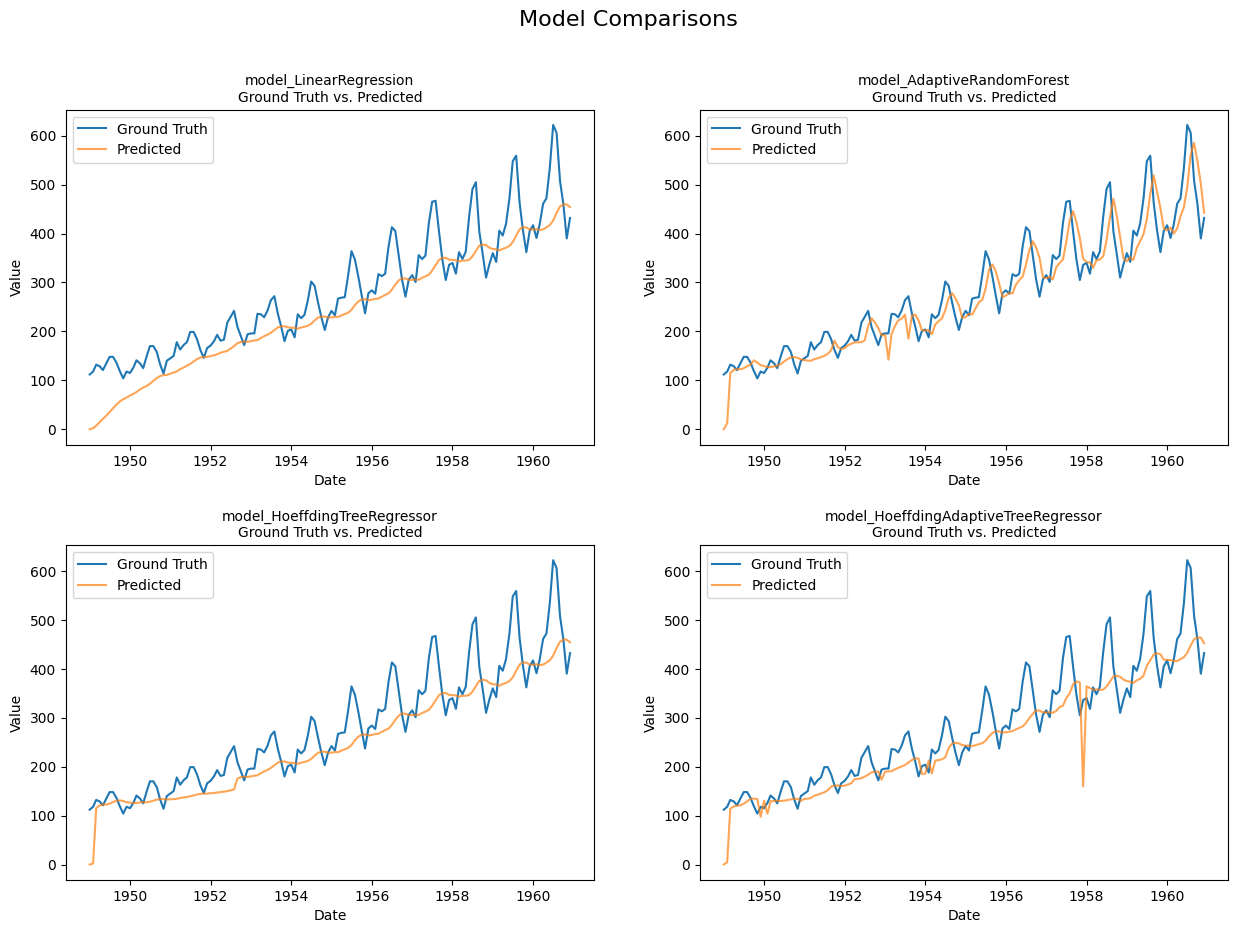

In [5]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10),gridspec_kw={'hspace': 0.3})
i = 0
for model_name, model in models.items():
    y_trues, y_preds, dates, metrics_dict, model = evaluate_model(model, 
                                                                 model_name = model_name,
                                                                 plotting_individual=False)
     # Add plot to the subplot grid
    ax = axs[i // 2, i % 2]
    ax.plot(dates, y_trues, label='Ground Truth')
    ax.plot(dates, y_preds, label='Predicted', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'{model_name}\nGround Truth vs. Predicted', fontsize=10)
    ax.legend()
    i+=1

# Display the overall title for the entire subplot
fig.suptitle('Model Comparisons', fontsize=16)
os.makedirs(save_folder, exist_ok=True)
save_path = os.path.join(save_folder, f'plot_comparaisons.png')
plt.savefig(save_path)
        
plt.show()
plt.close()  # Close the current figure to avoid overlapping plots
    
# Show the subplot
plt.show()


### Evaluate at different window sizes

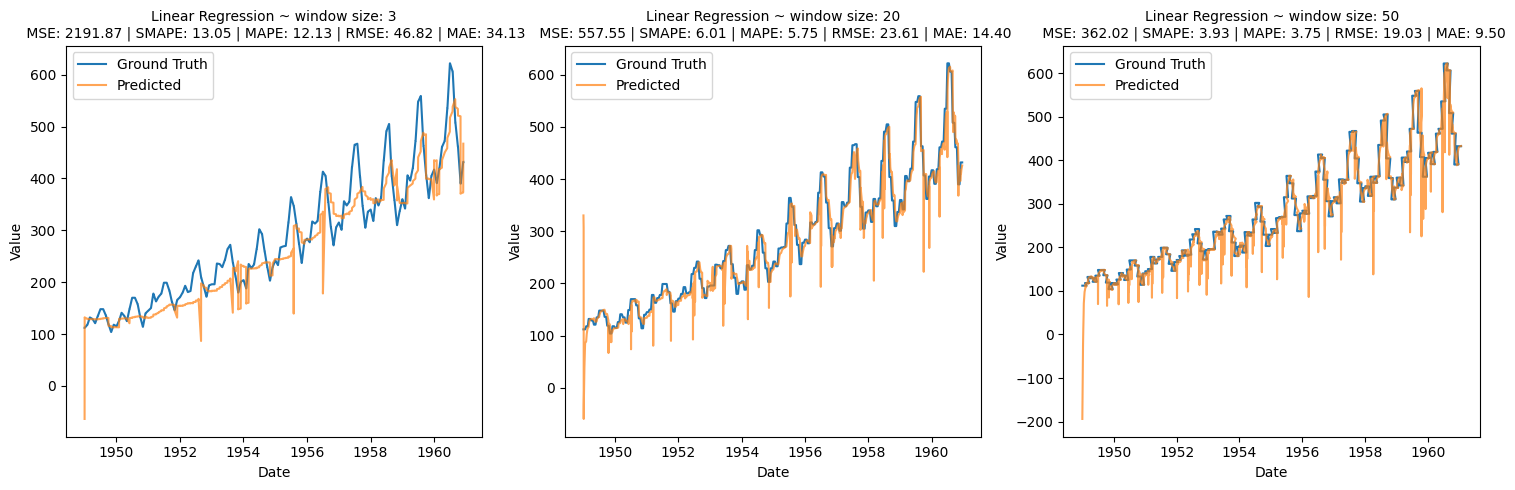

In [6]:
def evaluate_model_window(model,save_folder = "images", plotting=True, window_sizes=[3, 5, 10], model_name="Linear Regression"):
    dates = []
    y_trues = []
    y_preds = []

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for 3 windows

    for i, window_size in enumerate(window_sizes):

        upsampled_data = upsample_data(datasets.AirlinePassengers(), window_size)

        for x, y in upsampled_data:
            y_pred = model.predict_one(x)
            model.learn_one(x, y)

            dates.append(x['month'])
            y_trues.append(y)
            y_preds.append(y_pred)

        mse = round(mean_squared_error(y_trues, y_preds), 2)
        mae = round(mean_absolute_error(y_trues, y_preds), 2)
        smape = round(symmetric_mean_absolute_percentage_error(y_trues, y_preds), 2)
        mape = round(100 * mean_absolute_percentage_error(y_trues, y_preds), 2)
        rmse = round(np.sqrt(mse), 2)
        metrics_dict = {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'SMAPE': smape
        }
        axs[i].plot(dates, y_trues, label='Ground Truth')
        axs[i].plot(dates, y_preds, label='Predicted', alpha=0.7)
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Value')
        axs[i].set_title(f'{model_name} ~ window size: {window_size}\n MSE: {mse:.2f} | SMAPE: {smape:.2f} | MAPE: {mape:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}',
            fontsize=10)
        axs[i].legend()

        dates = []
        y_trues = []
        y_preds = []

    if plotting:
        plt.tight_layout()
        
        save_path = os.path.join(save_folder, f'plot_{model_name}.png')
        plt.savefig(save_path)
        
        plt.show()
        plt.close()


    return metrics_dict

def upsample_data(data, window_size):
    upsampled_data = []
    for x, y in data:
        for i in range(window_size):
            # Create new samples by shifting the original data
            new_x = {'month': x['month'] + timedelta(days=i)}
            new_y = y  # You might need to modify this depending on your data
            upsampled_data.append((new_x, new_y))
    return upsampled_data

window_sizes=[3, 20, 50]

evaluate_model_window(model, plotting=True, window_sizes=window_sizes, model_name="Linear Regression")
evaluate_model_window(model_AdaptiveRandomForest, plotting=True, window_sizes=window_sizes, model_name="Adaptive Random Forest")
evaluate_model_window(model_HoeffdingTreeRegressor, plotting=True, window_sizes=window_sizes, model_name="Hoeffding Tree Regressor")
evaluate_model_window(model_HoeffdingAdaptiveTreeRegressor, plotting=True, window_sizes=window_sizes, model_name="Adaptive Tree Regressor")